# meeting 5 anaylsis

## objectives:
1. try multiple triggers for now it is 252/63 and 60/20
2. create a table for three of them and compare the results
3. find the corrlation between our gold strategy and market


In [37]:
import pandas as pd 
import quantstats as qs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  
import warnings
warnings.filterwarnings('ignore')

In [38]:
pnl_data_path = '/Users/liubenchen/Desktop/Low-Tide-Capital-Management/data/pnl_data/XAUBNG.csv'
data =  pd.read_csv(pnl_data_path, parse_dates=['Date'])
data.columns

Index(['Date', 'Close', 'pct_change', 'sma252', 'sma63', 'sma20', 'sma60',
       'signal', 'position', 'start_time', 'equity_num', 'cash',
       'equity_value', 'net_value', 'equity_change', 'equity_curve',
       'close_pnl'],
      dtype='object')

In [39]:
mktdata = pd.read_csv('/Users/liubenchen/Desktop/Low-Tide-Capital-Management/data/pnl_data/60_40Ports.csv', parse_dates=['Date'])
mktdata.columns

Index(['Date', 'Bond', 'Stock', 'Bond_pctchange', 'Bond_pnl',
       'Stock_pctchange', 'Stock_pnl', 'ports_pctchange', 'ports_pnl'],
      dtype='object')

In [40]:
data = data.merge(mktdata[['Date', 'ports_pnl', 'ports_pctchange']], on='Date', how='left')
data.columns

Index(['Date', 'Close', 'pct_change', 'sma252', 'sma63', 'sma20', 'sma60',
       'signal', 'position', 'start_time', 'equity_num', 'cash',
       'equity_value', 'net_value', 'equity_change', 'equity_curve',
       'close_pnl', 'ports_pnl', 'ports_pctchange'],
      dtype='object')

In [41]:
ctaindex = pd.read_excel('/Users/liubenchen/Desktop/Low-Tide-Capital-Management/data/raw/NEIXCTA_Index.xlsx',
                            na_values=['#N/A N/A'],
                            parse_dates=['Date'],
                            index_col='Date')
ctaindex.columns
raw_data = pd.read_excel('/Users/liubenchen/Desktop/Low-Tide-Capital-Management/data/raw/equity_bond_gold.xlsx', na_values=['#N/A N/A'], sheet_name='equity_bond_gold_price', parse_dates=['Dates'])
print(raw_data.columns)
raw_data.rename(columns={'Dates':'Date'}, inplace=True)
data = data.merge(raw_data[['Date','LUATTRUU Index', 'SPXT Index', 'SPX Index', 'XAU Curncy']], on='Date', how='left')

Index(['Dates', 'LUATTRUU Index', 'SPXT Index', 'SPX Index', 'XAU Curncy'], dtype='object')


In [42]:
data = data.merge(ctaindex[['NEIXCTA']], on='Date', how='inner')
data.columns

Index(['Date', 'Close', 'pct_change', 'sma252', 'sma63', 'sma20', 'sma60',
       'signal', 'position', 'start_time', 'equity_num', 'cash',
       'equity_value', 'net_value', 'equity_change', 'equity_curve',
       'close_pnl', 'ports_pnl', 'ports_pctchange', 'LUATTRUU Index',
       'SPXT Index', 'SPX Index', 'XAU Curncy', 'NEIXCTA'],
      dtype='object')

In [43]:
def calculate_ema_trend(price_series, short_period = 63, long_period=252):
    df = pd.DataFrame(price_series)
    df['short_ema'] = price_series.ewm(span=short_period, adjust=False).mean()
    df['long_ema'] = price_series.ewm(span=long_period, adjust=False).mean()
    df['LT_trend'] = np.where(df['short_ema'] > df['long_ema'], 1, 0)
    return df[['short_ema', 'long_ema', 'LT_trend']]

data['alternative_signal'] = calculate_ema_trend(data['SPX Index'], short_period=63, long_period=252)['LT_trend']

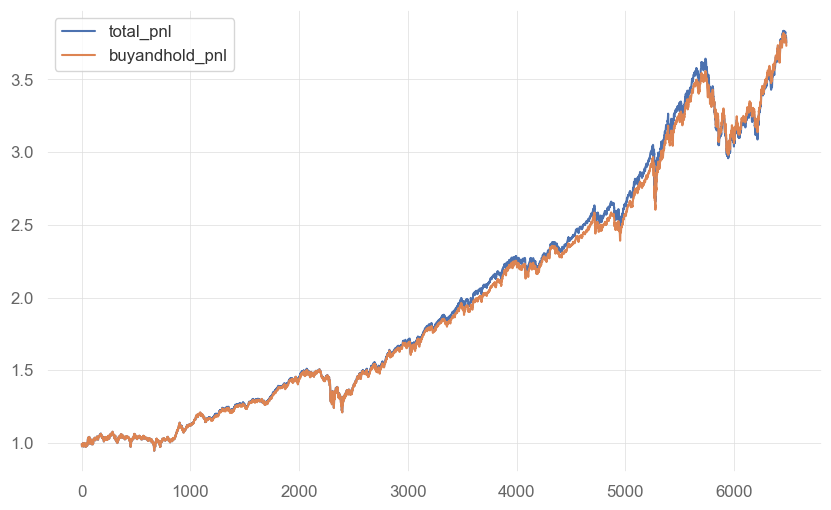

In [44]:
# using alternative signal to calculate the performance

data['ctaindexpctchange'] = data['NEIXCTA'].pct_change()
data['spypctchange'] = data['SPX Index'].pct_change()
data['total_pctchange'] = np.where(data['alternative_signal'] == 1, data['ports_pctchange']*1.1, data['ports_pctchange']+0.1*data['ctaindexpctchange'])
data['buyandhold_pctchange'] = data['ports_pctchange']+0.1*data['ctaindexpctchange']
# calc performance
data['total_pnl'] = (data['total_pctchange'] + 1).cumprod()
data['buyandhold_pnl'] = (data['buyandhold_pctchange'] + 1).cumprod()
data[['total_pnl', 'buyandhold_pnl']].plot()
data.to_csv('alldata.csv', index=False)

## 1. draw the triggers in the chart

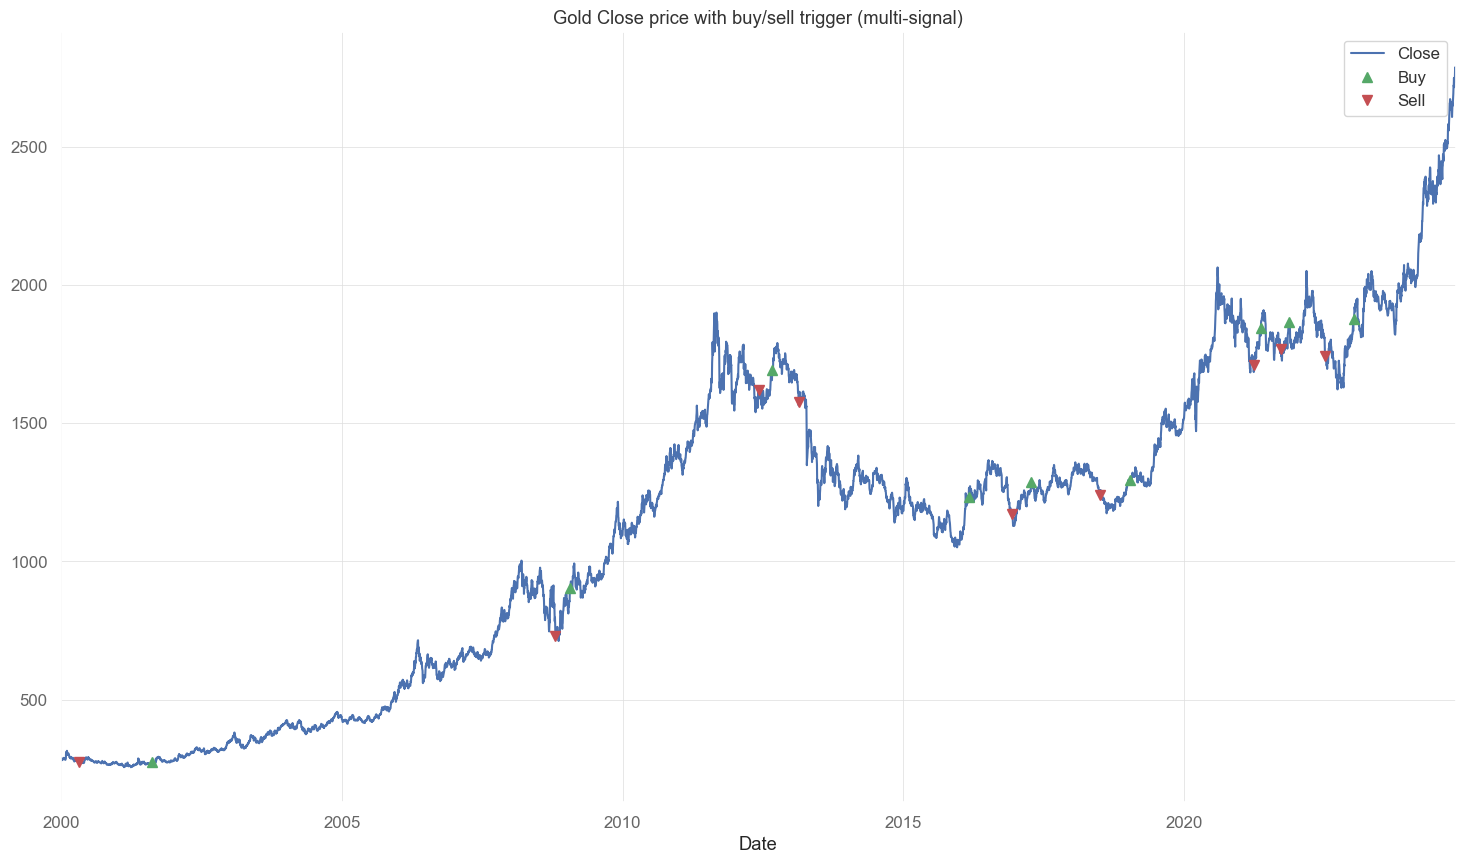

In [45]:
# plot the trigger in the data
data['trigger'] = data['signal'] - data['signal'].shift(1)
# if trigger is 1 then buy, if trigger is -1 then sell
# draw a graph about the Close price and the trigger
# and set the Date as the index
fig, ax = plt.subplots(figsize=(18, 10))
if 'Date' in data.columns:
    data.set_index('Date', inplace=True)
data['Close'].plot(ax=ax)
data['Close'][data['trigger'] == 1].plot(ax=ax, ls='', marker='^', markersize=7, color='g')
data['Close'][data['trigger'] == -1].plot(ax=ax, ls='', marker='v', markersize=7, color='r')
# add some notation
plt.legend(['Close', 'Buy', 'Sell'])
plt.title('Gold Close price with buy/sell trigger (multi-signal)')
plt.show()


In [46]:
def get_metrics(data):
    ret = {'sharp':round(qs.stats.sharpe(data, periods=12), 6),
    'avg_return':100 * round(qs.stats.avg_return(data), 6),
    'max_drawdown':100 * round(qs.stats.max_drawdown(data), 6),
    'win_rate':round(qs.stats.win_rate(data), 6),
    'calmar':round(qs.stats.calmar(data), 6),
    'volatility':round(qs.stats.volatility(data), 6),
    }
    
    annulized_return = data.mean() * 12
    ret['annulized_return'] = round(annulized_return, 6)
    return ret

## 2. static allocation about new ports and find the corr metrix

In [47]:
port_dict = {'6040Ports': data['ports_pctchange'], 'Strategy': data['equity_change'], 'Gold': data['Close'].pct_change()}
for i in [0.05, 0.1, 0.2, 0.3, 0.4]:
    port_dict[f'Mixed Ports {i}'] = data['equity_change'] * i + data['ports_pctchange']
metrics_dict = {}
for key in port_dict.keys():
    # convert to monthly data
    port_dict[key] = port_dict[key].resample('M').apply(lambda x: (x + 1).prod() - 1)
    metrics_dict[key] = get_metrics(port_dict[key])


metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,6040Ports,Strategy,Gold,Mixed Ports 0.05,Mixed Ports 0.1,Mixed Ports 0.2,Mixed Ports 0.3,Mixed Ports 0.4
sharp,0.797257,0.606376,0.644020,0.845187,0.881511,0.923585,0.935946,0.931106
avg_return,0.418600,0.923000,0.862000,0.454800,0.491100,0.563400,0.635700,0.707800
max_drawdown,-17.791600,-26.072000,-41.875100,-17.736800,-18.022200,-19.552300,-21.249500,-22.968100
win_rate,0.646667,0.530435,0.541806,0.643333,0.626667,0.623333,0.640000,0.630000
calmar,0.190501,0.204349,0.153615,0.208194,0.221567,0.234496,0.243046,0.249555
volatility,0.288710,0.641742,0.733545,0.295930,0.306336,0.335468,0.373483,0.418018
annulized_return,0.050228,0.084917,0.103090,0.054580,0.058927,0.067611,0.076280,0.084935


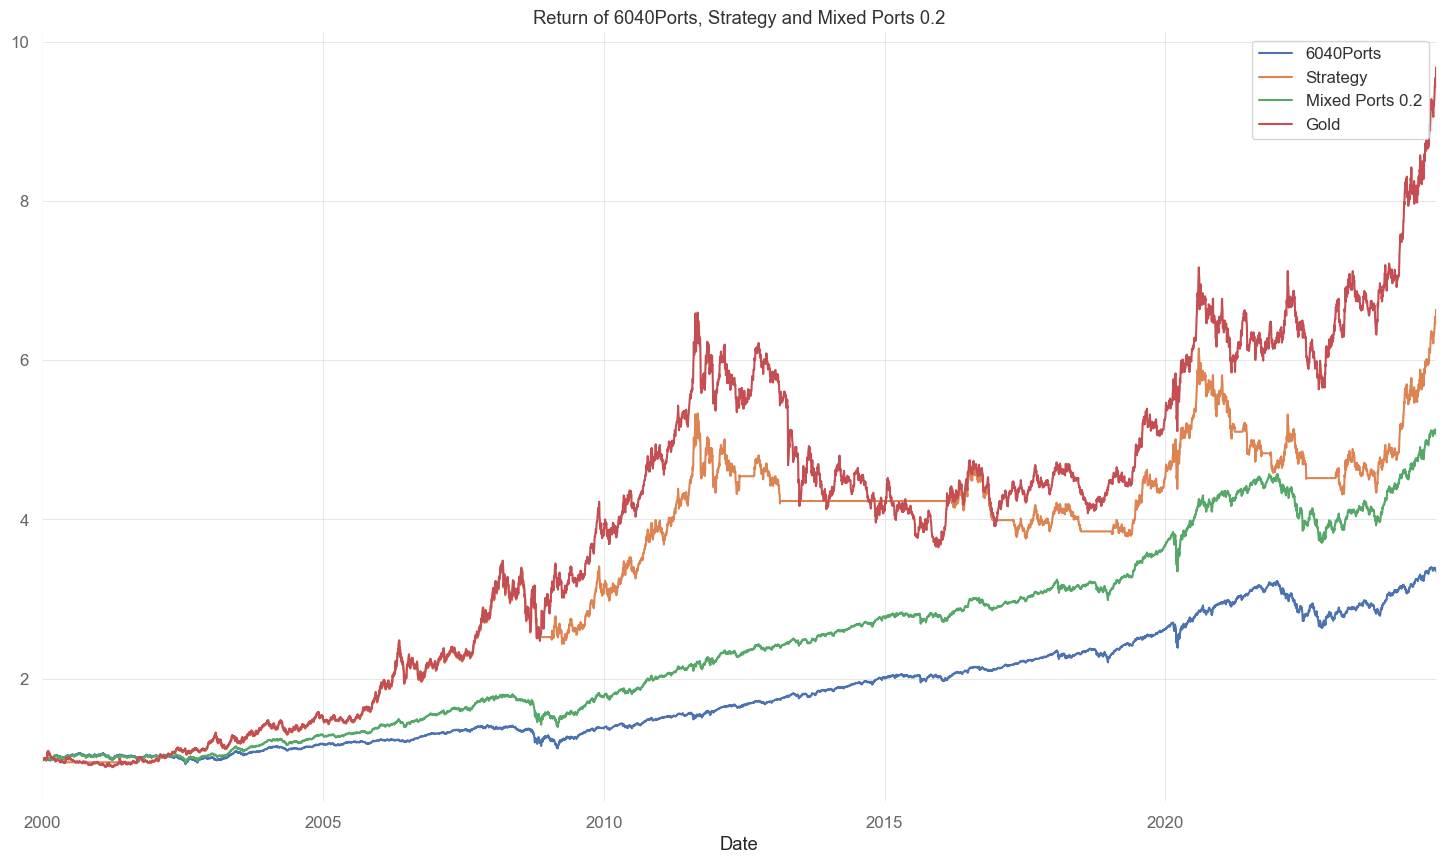

In [48]:
# draw the equity curve of 6040Ports, Strategy and Mixed Ports 0.2
specified_dict = {'6040Ports': data['ports_pctchange'], 'Strategy': data['equity_change'], 'Mixed Ports 0.2': data['equity_change'] * 0.2 + data['ports_pctchange'], 'Gold': data['Close'].pct_change()}
fig, ax = plt.subplots(figsize=(18, 10))
# calc log return
for key in specified_dict.keys():
    specified_dict[key] = specified_dict[key].apply(lambda x: (x + 1)).cumprod()
    # calc max drawdown and drawdown duration not using quantstats
    specified_dict[key].plot(ax=ax)
    
plt.legend(specified_dict.keys())
plt.title('Return of 6040Ports, Strategy and Mixed Ports 0.2')
plt.show()


<Axes: >

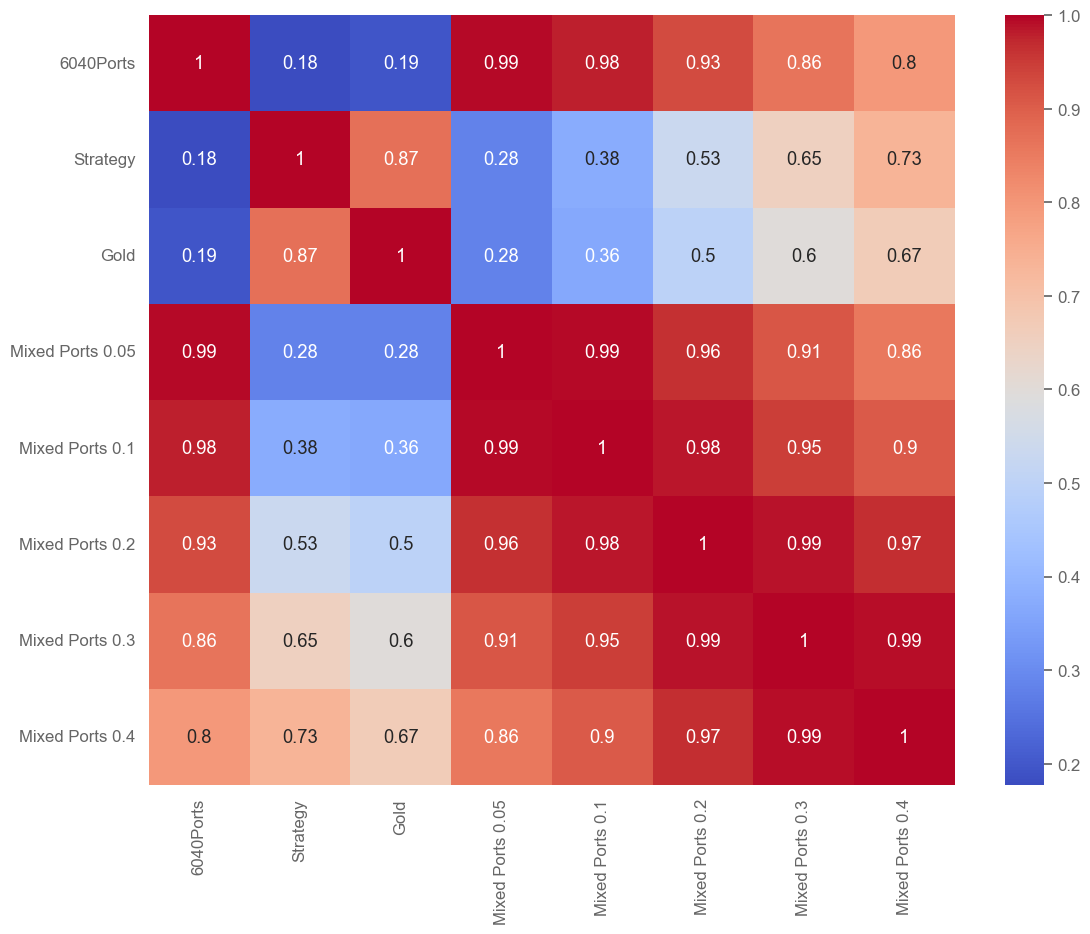

In [49]:
# plot the corrlation matrix
corr = pd.DataFrame(port_dict).corr()
figsize = (13, 10)
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)

# meeting 6 anaylsis
**objectives :**
1. Investigate the largest drawdown periods. When does it occur? How long does it take to recover? And what was happening to gold in that period?


6040Ports


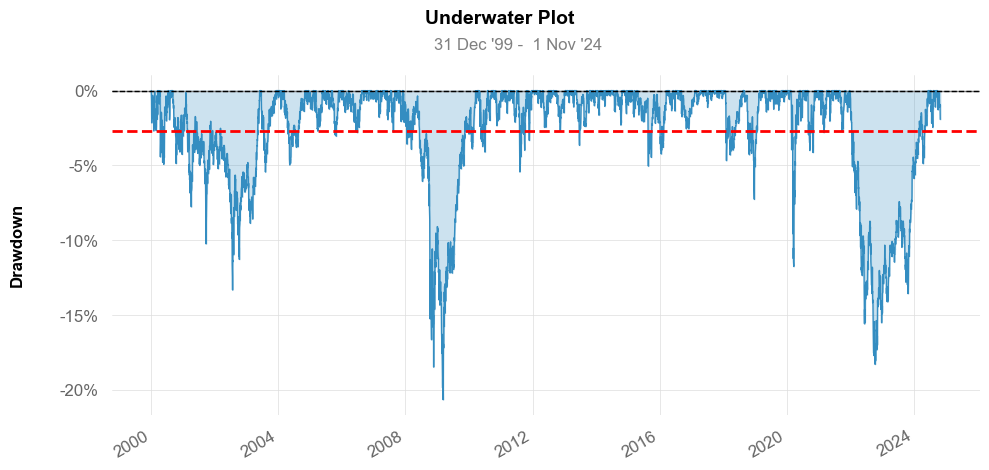

Strategy


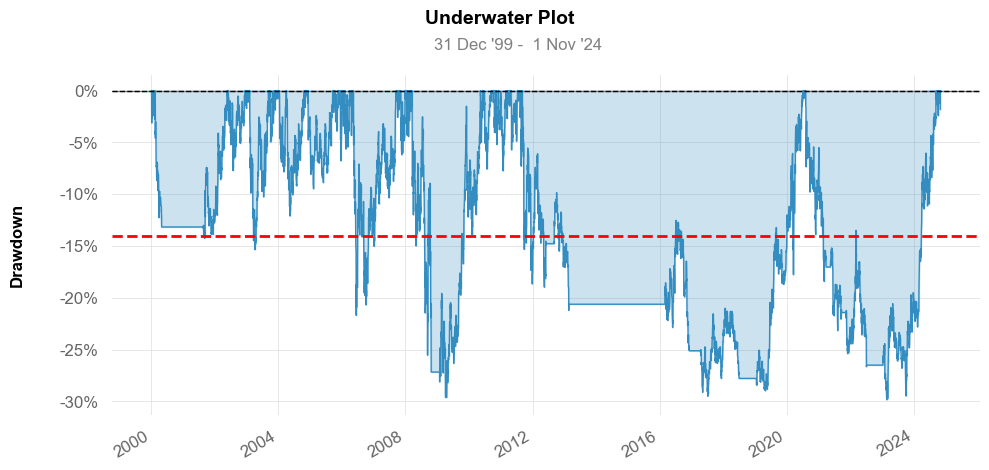

Mixed Ports 0.2


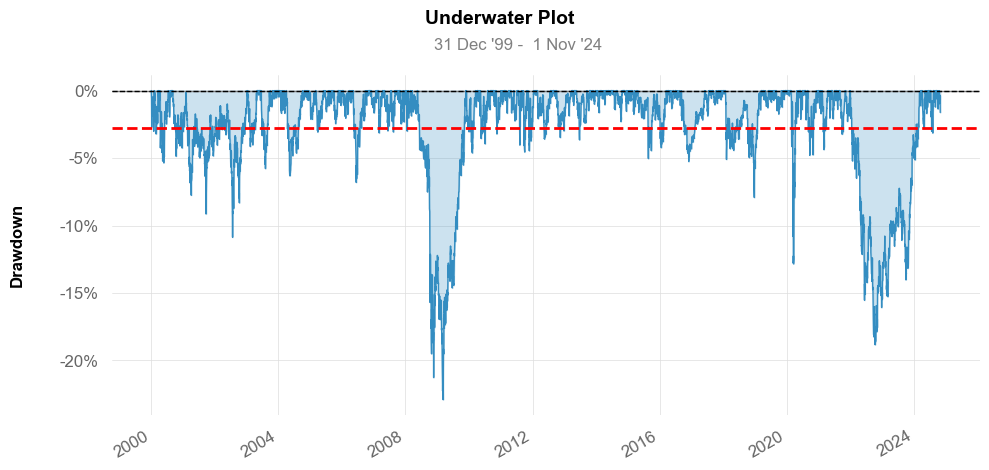

Gold


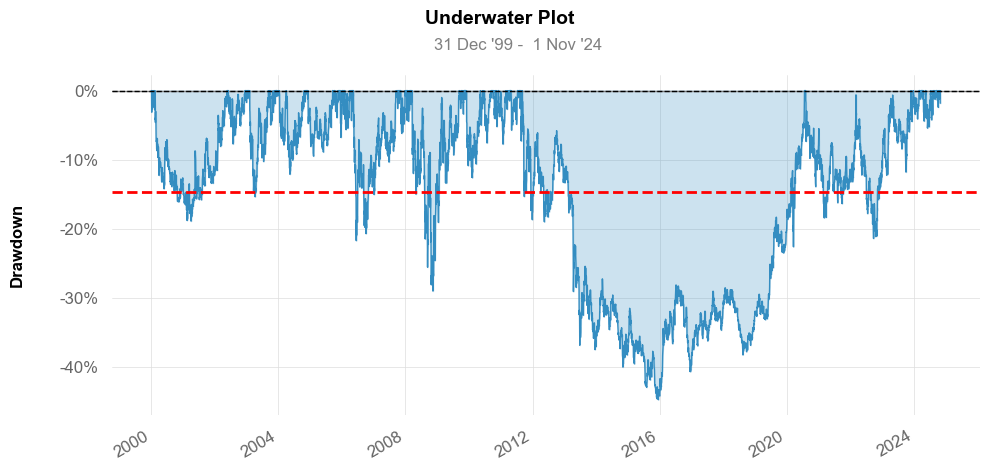

In [50]:
def maxdrawdown_details(name, data):
    qs.plots.drawdown(data, subtitle=name+' Max Drawdown')

for key, val in specified_dict.items():
    print(key)
    fig = maxdrawdown_details(key, val)

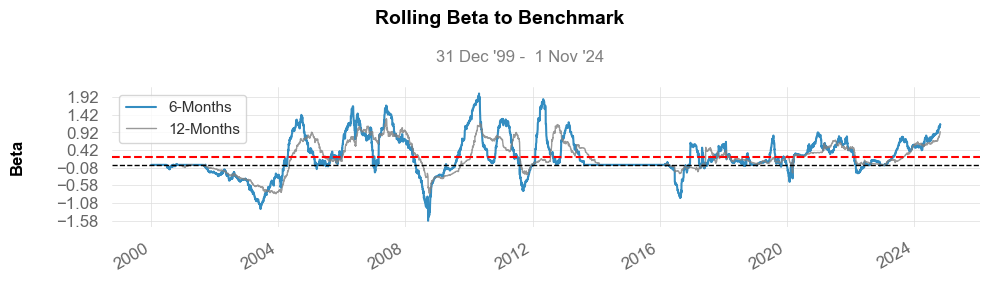

In [51]:
qs.plots.rolling_beta(data['equity_change'], data['ports_pctchange'])

In [52]:
def get_drawdown_detail(data, name):
    drawdownseries = qs.stats.to_drawdown_series(data)
    drawdown_details = qs.stats.drawdown_details(drawdown=drawdownseries)
    return drawdown_details

# use 2 level table to show the drawdown details in specified_dict
drawdown_dict = {}
for key, val in specified_dict.items():
    detail = get_drawdown_detail(val, key)
    detail.sort_values(by='max drawdown', ascending=True, inplace=True)
    detail.reset_index(inplace=True, drop=True)
    drawdown_dict[key] = detail.head(5)
# set key as the first level index, and the second level index is the drawdown details
drawdown_df = pd.concat(drawdown_dict, axis=0)
drawdown_df

start      valley         end  days  max drawdown  \
6040Ports       0  2007-12-07  2009-03-09  2010-03-22   837    -20.631417   
                1  2021-12-28  2022-10-14  2024-06-12   898    -18.270532   
                2  2000-09-05  2002-07-23  2003-06-02  1001    -13.304866   
                3  2020-02-21  2020-03-23  2020-05-26    96    -11.741381   
                4  2018-08-30  2018-12-24  2019-03-11   194     -7.252276   
Strategy        0  2020-08-07  2023-02-24  2024-09-13  1499    -29.828475   
                1  2008-03-17  2009-04-17  2010-05-11   786    -29.617514   
                2  2011-09-06  2017-07-07  2020-07-06  3227    -29.495415   
                3  2006-05-15  2006-06-14  2007-09-14   488    -21.691381   
                4  2003-02-05  2003-04-08  2003-09-08   216    -15.344261   
Mixed Ports 0.2 0  2008-05-21  2009-03-09  2009-11-24   553    -22.906635   
                1  2021-12-28  2022-10-14  2024-03-19   813    -18.835835   
                2  2020-02-24  2020-03-20  2020-04-28    65    -12.840860   
                3  2000-09-05  2002-07-23  2003-01-03   851    -10.868219   
                4  2018-01-29  2018-12-24  2019-03-14   410     -7.923262   
Gold            0  2011-09-06  2015-12-17  2020-07-23  3244    -44.684770   
                1  2008-03-17  2008-11-12  2009-09-10   543    -28.980955   
                2  2006-05-15  2006-06-14  2007-09-14   488    -21.691382   
                3  2020-08-07  2022-09-26  2023-11-30  1211    -21.379765   
                4  2000-02-11  2001-04-02  2002-05-17   827    -18.873016   

                   99% max drawdown  
6040Ports       0        -18.834587  
                1        -17.502795  
                2        -10.827908  
                3        -11.440224  
                4         -6.378031  
Strategy        0        -29.053932  
                1        -28.580640  
                2        -28.608260  
                3        -19.837716  
                4        -14.793441  
Mixed Ports 0.2 0        -21.832614  
                1        -18.096837  
                2        -12.779148  
                3         -8.734281  
                4         -6.278673  
Gold            0        -43.543837  
                1        -27.161232  
                2        -19.837717  
                3        -20.289406  
                4        -17.952381